In [1]:
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import matplotlib.pyplot as plt
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator, EncoderDecoderModel, AutoTokenizer
from torch.utils.data import Dataset
import os
from datasets import load_metric


c:\Users\ASUS\anaconda3\envs\trocr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


In [2]:
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

print(f"Current device: {device}")


CUDA is not available. Using CPU.
Current device: cpu


In [7]:
df = pd.read_csv(r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DATA _TrOCR\OCR_clean.csv')
print(df.head())

                                           file_path ground_truth
0  /home/mrunali/indic_ocr/trOCR/data/english_hw_...           it
1  /home/mrunali/indic_ocr/trOCR/data/english_hw_...            a
2  /home/mrunali/indic_ocr/trOCR/data/english_hw_...          and
3  /home/mrunali/indic_ocr/trOCR/data/english_hw_...          but
4  /home/mrunali/indic_ocr/trOCR/data/english_hw_...         that


In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [10]:
test_df

,file_path,ground_truth
0,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,JUSTINE
1,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,MADEN
2,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,TIRMAN
3,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,EVA
4,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,CLEMENT
...,...,...
68103,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,THIBAULT
68104,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,LEA
68105,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,BARACHET
68106,/home/mrunali/indic_ocr/trOCR/data/english_hw_...,SHAINA


In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.image_paths = self._collect_image_paths()

    def _collect_image_paths(self):
        image_paths = {}
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(('.tif', '.jpg', '.png')):  # Add other image formats if needed
                    image_paths[file] = os.path.join(root, file)
        return image_paths

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file name + text
        full_file_path = self.df['TIF_File_Path'].iloc[idx]
        text = self.df['Ground_Truth'].iloc[idx]
        
        # Ensure the text is of type str
        text = str(text)

        # Extract just the file name from the full path
        file_name = os.path.basename(full_file_path)

        # Prepare image (i.e., resize + normalize)
        image_path = self.image_paths.get(file_name)

        if image_path is None:
            raise FileNotFoundError(f"Image {file_name} not found in {self.root_dir}")

        image = Image.open(image_path).convert("RGB")
        
        # Resize image to expected size (example: 224x224), you can change it based on your model's requirement
        image = image.resize((224, 224))
        
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        
#         print("labels:",labels)
#         print("labels type:",type(labels))
        # Important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [8]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# Usage
train_dataset = CustomDataset(
    root_dir=r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\words', 
    df=train_df, 
    processor=processor
)
eval_dataset = CustomDataset(
    root_dir=r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\words', 
    df=test_df, 
    processor=processor
)

# Example to access the first item
encoding = train_dataset[0]
for k, v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [9]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 8611
Number of validation examples: 2153


In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

In [ ]:
# MODEL_NAME = "microsoft/trocr-base-handwritten"
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)
model.gradient_checkpointing_enable()
torch.cuda.empty_cache()

In [ ]:
cer_metric = load_metric("cer")

from datasets import load_metric
cer_metric = load_metric("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

In [ ]:
model.gradient_checkpointing_enable()

# Define the compute_metrics function
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

# Adjust training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,  # Reduced batch size
    per_device_eval_batch_size=2,# Reduced batch size
    gradient_accumulation_steps=4,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

# Clear GPU cache before starting
# model = model.to(device)
    

# Instantiate the trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

In [ ]:
# Start the training process
trainer.train()

INFERENCE


In [2]:

# Path to the directory where your model and processor checkpoints are saved
MODEL_PATH= r"C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\Trained_model\checkpoint-1614/"

# Load the processor and model from the checkpoint
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
model = VisionEncoderDecoderModel.from_pretrained(MODEL_PATH)





c:\Users\ASUS\anaconda3\envs\trocr\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--microsoft--trocr-base-stage1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

Predicted Text: Nomacs


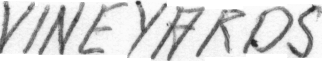

In [4]:

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    # Resize the image to match the input size expected by the model
    # image = image.resize((224, 224))
    return image

# Path to the new image for inference
image_path = r"C:\Users\ASUS\Downloads\d03-112-01-00.png"
image = preprocess_image(image_path)
pixel_values = processor(image, return_tensors="pt").pixel_values

# Move pixel values to GPU if available
pixel_values = pixel_values.to(device)

# Set the model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    outputs = model.generate(pixel_values)

# Move the predictions back to CPU if necessary
pred_ids = outputs.cpu()

# Decode the predictions
predicted_text = processor.batch_decode(pred_ids, skip_special_tokens=True)[0]

print("Predicted Text:", predicted_text)
image

In [5]:
import pandas as pd

# Define the dictionary using raw strings
data = {
    'Path': [
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-00.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-01.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-02.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-03.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-04.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-07.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-01-01.png'
    ],
    'Ground_Truth': ['short', 'of', 'wearing', 'the', 'same', 'which', 'contemplated']
}

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                                                Path  Ground_Truth
0  C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...         short
1  C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...            of
2  C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...       wearing
3  C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...           the
4  C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...          same
5  C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...         which
6  C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...  contemplated


In [7]:


# Load the CER metric
cer_metric = load_metric("cer")

def infer(image_path, ground_truth):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Process the image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Move the pixel values to the appropriate device
    pixel_values = pixel_values.to(model.device)

    # Generate the text
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Calculate CER
    cer = cer_metric.compute(predictions=[generated_text], references=[ground_truth])

    return generated_text, cer

# Example usage
image_path = r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DATA _TrOCR\a05-004-00-00.png'
ground_truth = "short"
predicted_text, cer = infer(image_path, ground_truth)

print(f"Predicted Text: {predicted_text}")
print(f"CER: {cer}")



Using the latest cached version of the module from C:\Users\ASUS\.cache\huggingface\modules\datasets_modules\metrics\cer\46482e3826224451c26c9b51d8d193d38a4226daab693df497d2e397b623274e (last modified on Wed Jun 26 16:22:44 2024) since it couldn't be found locally at cer, or remotely on the Hugging Face Hub.


Predicted Text: sheet
CER: 0.4


In [27]:
def infer(image_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Process the image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Move the pixel values to the appropriate device
    pixel_values = pixel_values.to(model.device)

    # Generate the text
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

predictions = []
ground_truths = df['Ground_Truth'].tolist()

# Perform inference on each image
for image_path in df['Path']:
    predicted_text = infer(image_path)
    predictions.append(predicted_text)

# Calculate CER
cer = cer_metric.compute(predictions=predictions, references=ground_truths)

# Print results
for i, (pred, gt) in enumerate(zip(predictions, ground_truths)):
    print(f"Image {i+1}:")
    print(f"  Ground Truth: {gt}")
    print(f"  Prediction:  {pred}")
    
    print(f"CER: {cer}")
    df['cer']


KeyError: 'Ground_Truth'

In [25]:

data = {
    'Path': [
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-00.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-01.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-02.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-03.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-04.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-00-07.png',
        r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05-004-01-01.png'
    ],
    'Actual_Text': ['short', 'of', 'wearing', 'the', 'same', 'which', 'contemplated'],
    'Predicted_Text': ['sheet', 'of', 'working', 'the', 'same', 'which', 'computer'],
    'CER': [0.2894736842105263] * 7 
}

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_path = r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\infer.csv'
df.to_csv(csv_path, index=False)




In [26]:
DF = pd.read_csv(r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\infer.csv')
DF

,Path,Actual_Text,Predicted_Text,CER
0,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...,short,sheet,0.289474
1,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...,of,of,0.289474
2,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...,wearing,working,0.289474
3,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...,the,the,0.289474
4,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...,same,same,0.289474
5,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...,which,which,0.289474
6,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\a05...,contemplated,computer,0.289474


In [12]:
import pandas as pd
df1 = pd.read_csv(r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DATA _TrOCR\tif_filesAll2_cleaned.csv')
df2 = pd.read_csv(r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DATA _TrOCR\written_name_train.csv')

In [21]:
df2

,TIF_FILE_PATH,Ground_Truth
0,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,BALTHAZAR
1,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,SIMON
2,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,BENES
3,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,LA LOVE
4,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,DAPHNE
...,...,...
330956,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,LENNY
330957,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,TIFFANY
330958,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,COUTINHO DESA
330959,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,MOURAD


In [19]:
File_paths=df1['TIF_File_Path']
grount_truth=df1['Ground_Truth']


In [23]:
File_paths2=df2['TIF_FILE_PATH']
grount_truth2=df2['Ground_Truth']

print(File_paths2)

0         C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
1         C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
2         C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
3         C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
4         C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
                                ...                        
330956    C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
330957    C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
330958    C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
330959    C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
330960    C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...
Name: TIF_FILE_PATH, Length: 330961, dtype: object


In [25]:
import numpy as np

In [26]:
combined_file_paths=np.concatenate([File_paths,File_paths2])
combined_ground_truth=np.concatenate([grount_truth,grount_truth2])

In [29]:
data = {
    'file_path': combined_file_paths,
    'ground_truth': combined_ground_truth
}

combined_df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
combined_df.to_excel('combined_excel_files.xlsx', index=False)

print("Excel file 'combined_data.xlsx' has been created successfully.")

Excel file 'combined_data.xlsx' has been created successfully.


In [3]:
data = pd.read_excel(r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\combined_excel_files.xlsx')
data = data.iloc[614:]
data.head()


,file_path,ground_truth
614,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,it
615,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,a
616,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,and
617,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,but
618,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,that


In [4]:
new_path = r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\Train_Data.csv'
data.to_csv(new_path , index= False)

In [5]:
df = pd.read_csv(r'C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\Train_Data.csv')
df

,file_path,ground_truth
0,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,it
1,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,a
2,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,and
3,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,but
4,C:\Users\ASUS\OneDrive\Desktop\EnglishDataSetW...,that
...,...,...
341106,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,LENNY
341107,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,TIFFANY
341108,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,COUTINHO DESA
341109,C:\Users\ASUS\OneDrive\Desktop\TROCR_MODEL\DAT...,MOURAD
